In [1]:
# Import required libraries
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from scipy import io
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.utils import to_categorical

# HODA Dataset - Softmax Classification with CNN

This notebook demonstrates training a Convolutional Neural Network (CNN) for digit classification using the HODA dataset with softmax activation.


In [2]:
# Import MATLAB dataset with scipy.io
dataset = io.loadmat(r"C:\Users\11\Documents\Machine Learning\09 Projects\02 hoda softmax\data\Data_hoda_full.mat")

## 1. Data Loading and Exploration


In [3]:
# Load and prepare data
X = np.squeeze(dataset['Data'])  # Remove extra dimension from MATLAB format
Y = np.squeeze(dataset['labels'])
print(f"Data shape: {X.shape}")
print(f"Label shape: {Y.shape}")

Data shape: (60000,)
Label shape: (60000,)


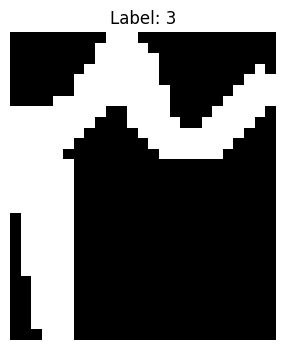

In [4]:
# Display a sample image
numd = 280
plt.figure(figsize=(4, 4))
plt.imshow(X[numd], cmap='grey')
plt.title(f"Label: {Y[numd]}")
plt.axis('off')
plt.show()

## 2. Image Preprocessing - Resizing


Resized data shape: (60000, 30, 30)


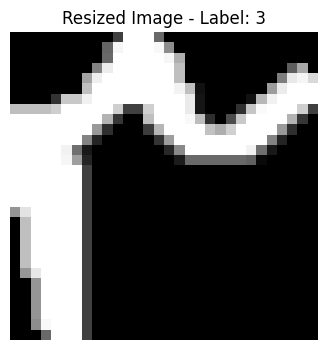

In [5]:
# Resize all images to fixed size
IMAGE_SIZE = 30
X_resized_list = [cv.resize(img, (IMAGE_SIZE, IMAGE_SIZE)) for img in X]
X = np.stack(X_resized_list)

print(f"Resized data shape: {X.shape}")

# Display resized sample
plt.figure(figsize=(4, 4))
plt.imshow(X[numd], cmap='grey')
plt.title(f"Resized Image - Label: {Y[numd]}")
plt.axis('off')
plt.show()

## 3. Data Splitting: Train, Validation, and Test Sets


In [6]:
# Split data into Train (90%), Validation (5%), and Test (5%)
RANDOM_SEED = 42
TEST_SIZE = 0.05

# Step 1: Split off Test set (5%)
X_temp, X_test, Y_temp, Y_test = train_test_split(
    X, Y, test_size=TEST_SIZE, random_state=RANDOM_SEED, shuffle=True, stratify=Y
)

# Step 2: Split remaining into Train (90%) and Validation (5%)
VAL_FROM_TEMP_RATIO = 0.05 / 0.95
X_train, X_validation, Y_train, Y_validation = train_test_split(
    X_temp, Y_temp, test_size=VAL_FROM_TEMP_RATIO, random_state=RANDOM_SEED, shuffle=True, stratify=Y_temp
)

print(f"Train: {X_train.shape[0]} samples (90%)")
print(f"Validation: {X_validation.shape[0]} samples (5%)")
print(f"Test: {X_test.shape[0]} samples (5%)")

Train: 53999 samples (90%)
Validation: 3001 samples (5%)
Test: 3000 samples (5%)


## 4. Data Preprocessing for CNN


In [7]:
# Define constants
NUM_CLASSES = 10  # Digits 0-9
CHANNEL_COUNT = 1  # Grayscale images

# Reshape data for CNN: (samples, height, width, channels)
X_train = X_train.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, CHANNEL_COUNT)
X_validation = X_validation.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, CHANNEL_COUNT)
X_test = X_test.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, CHANNEL_COUNT)

# Normalize pixel values to [0, 1]
X_train = X_train / 255.0
X_validation = X_validation / 255.0
X_test = X_test / 255.0

# One-Hot encode labels
Y_train = to_categorical(Y_train, num_classes=NUM_CLASSES)
Y_validation = to_categorical(Y_validation, num_classes=NUM_CLASSES)
Y_test = to_categorical(Y_test, num_classes=NUM_CLASSES)

print(f"Preprocessed X_train shape: {X_train.shape}")
print(f"Preprocessed Y_train shape: {Y_train.shape}")

Preprocessed X_train shape: (53999, 30, 30, 1)
Preprocessed Y_train shape: (53999, 10)


## 5. Model Architecture Definition


In [8]:
# Define CNN model
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNEL_COUNT)

model = Sequential([
    Input(shape=INPUT_SHAPE),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 804,554 (3.07 MB)

 Trainable params: 804,554 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Model Compilation


In [9]:
# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## 7. Model Training


In [10]:
# Train model
history = model.fit(
    X_train, Y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_validation, Y_validation),
    verbose=1
)

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9741 - loss: 0.0880 - val_accuracy: 0.9867 - val_loss: 0.0436
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9919 - loss: 0.0256 - val_accuracy: 0.9897 - val_loss: 0.0342
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9955 - loss: 0.0136 - val_accuracy: 0.9917 - val_loss: 0.0256
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9971 - loss: 0.0075 - val_accuracy: 0.9917 - val_loss: 0.0267
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9981 - loss: 0.0057 - val_accuracy: 0.9947 - val_loss: 0.0239


## 8. Model Evaluation


In [11]:
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(X_validation, Y_validation, verbose=0)
print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f"Test - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

Validation - Loss: 0.0239, Accuracy: 0.9947
Test - Loss: 0.0299, Accuracy: 0.9950
